# 1. Introduction
# ICU Survival Cox and Predictive Models

**Approach**  
Part 2 moves from description (KM Curve) to inference with the Cox proportional hazards model (CPH), and then to prediction with supervised classifiers at fixed horizons

**Learning goals**  
- Fit and interpret a Cox proportional hazards model in lifelines  
- Check the proportional hazards assumption and address violations  
- Translate hazard ratios into individualized survival curves  
- Build and evaluate predictive classifiers for in-hospital mortality and fixed horizons at 7, 30, and 60 days  
- Compare Cox risk with classifier probabilities using discrimination and calibration metrics  
- Avoid data leakage and ensure reproducible 70 percent, 20 percent, 10 percent splits

**Methods and data**  
- Data  
  • [PhysioNet Challenge 2012 dataset](https://physionet.org/content/challenge-2012/1.0.0/), Set A aggregate file  
  • We standardize to `duration_days` and `event_death` to keep Part 1 and Part 2 consistent  

- Software  
  • lifelines for Cox and diagnostics  
  • scikit-learn for preprocessing, classifiers, and calibration  
  • scikit-survival for time-dependent AUC and integrated Brier score  

**Key references**  
- PhysioNet Challenge 2012 overview and dataset  
  • https://physionet.org/challenge/2012/  
- lifelines CoxPHFitter and assumption checks  
  • https://lifelines.readthedocs.io/en/latest/fitters/regression/CoxPHFitter.html  
- scikit-learn documentation  
  • Pipeline and ColumnTransformer: https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html  
  • CalibrationDisplay: https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibrationDisplay.html  
  • Brier score: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.brier_score_loss.html  
- scikit-survival time-dependent metrics  
  • cumulative_dynamic_auc: https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.metrics.cumulative_dynamic_auc.html


# 2. Setup

In [18]:
# Setup and reproducibility

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import os
import sys
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Survival modeling
import lifelines
from lifelines import KaplanMeierFitter, CoxPHFitter, AalenJohansenFitter

# Scikit-learn core utilities
import sklearn
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    brier_score_loss,
    RocCurveDisplay,
    PrecisionRecallDisplay
)
from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold
from sksurv.nonparametric import cumulative_incidence_competing_risks
from sksurv.util import Surv
from sksurv.metrics import cumulative_dynamic_auc, brier_score
from sklearn.isotonic import IsotonicRegression

# Persistence
import joblib

# Local helpers supplied with Part 1
import utils

# Optional scikit-survival for time-dependent metrics
SKSURV_AVAILABLE = False
try:
    from sksurv.metrics import cumulative_dynamic_auc, integrated_brier_score
    from sksurv.util import Surv
    SKSURV_AVAILABLE = True
except ImportError as e:
    print("scikit-survival not available. Time-dependent metrics will be skipped.")
    print(f"Import error: {e}")

# Global configuration
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Matplotlib defaults for simple, readable figures
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 11

# Show library versions for reproducibility
def _get_ver(mod):
    return getattr(mod, "__version__", "n/a")

print("Versions")
print(f"python              : {sys.version.split()[0]}")
print(f"numpy               : {_get_ver(np)}")
print(f"pandas              : {_get_ver(pd)}")
print(f"lifelines           : {_get_ver(lifelines)}")
print(f"scikit-learn        : {_get_ver(sklearn)}")
print(f"scikit-survival     : {'available' if SKSURV_AVAILABLE else 'not available'}")

# Ensure consistent display
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

Versions
python              : 3.11.13
numpy               : 2.3.3
pandas              : 2.3.3
lifelines           : 0.30.0
scikit-learn        : 1.7.2
scikit-survival     : available


# 3. Load data and define variables

### Predictor selection and leakage control

- We will use only variables that are known or measured at or near ICU admission (avoids hindsight bias and leakage)
- We will exclude any variable that is a direct consequence of the outcome or occurs late in the stay (post-outcome signals inflate accuracy)
- We will explicitly drop `Length_of_stay` and any outcome derived fields to avoid label leakage (leak outcome information into predictors)
- We will keep preprocessing simple and transparent to support clinical interpretability

In [19]:
# --- 1. Load Data ---
PATH = "PhysionetChallenge2012-set-a.csv.gz"

# Simple check to ensure the data file exists before trying to load it
if not os.path.exists(PATH):
    raise FileNotFoundError(
        f"Error: The data file was not found at '{PATH}'. "
        "Please ensure the dataset is in the correct directory."
    )

ICU = pd.read_csv(PATH, compression="gzip")

# --- 2. Find and Standardize Survival Columns ---
# Prefer 'Survival' for duration, as it's the target in the Challenge documentation
duration_col = "Survival"
event_col = "In-hospital_death"

if duration_col not in ICU.columns or event_col not in ICU.columns:
    raise ValueError(f"Could not find required columns: '{duration_col}' or '{event_col}'")

# Create standardized fields for consistency across notebooks
ICU["duration_days"] = ICU[duration_col].astype(float)
ICU["event_death"] = ICU[event_col].astype(int)

# --- 3. Validate and Clean Data ---
# Keep only rows with valid survival data
ICU.dropna(subset=["duration_days", "event_death"], inplace=True)
ICU = ICU[ICU["event_death"].isin([0, 1])].copy() # Ensure event is 0 or 1

# A key step in survival analysis: time must be positive
non_positive_durations = ICU["duration_days"] <= 0
if non_positive_durations.any():
    print(f"Watch Out: Dropping {non_positive_durations.sum()} rows with non-positive survival time.")
    ICU = ICU[~non_positive_durations].copy()


# --- 4. Final Data Summary ---
print(f"Data successfully loaded and cleaned. Final dataset has {len(ICU)} rows.")

# Display a preview of key columns as a formatted table
print("\nPreview of standardized data:")
preview_cols = ["duration_days", "event_death", "Age", "Gender", "SAPS-I", "SOFA"]
preview_cols = [c for c in preview_cols if c in ICU.columns]
display(ICU[preview_cols].head())

# Display descriptive statistics for the survival variables
print("\nDescriptive statistics for survival variables:")
display(ICU[["duration_days", "event_death"]].describe())

# Display the final counts of events vs. censored cases
print("\nEvent and censoring counts:")
display(ICU["event_death"].value_counts().rename({0: "Censored (Discharged)", 1: "Event (Death)"}).to_frame("Count"))

Watch Out: Dropping 2529 rows with non-positive survival time.
Data successfully loaded and cleaned. Final dataset has 1471 rows.

Preview of standardized data:


,duration_days,event_death,Age,Gender,SAPS-I,SOFA
3,575.0,0,68.0,1.0,7,1
4,918.0,0,88.0,0.0,17,2
5,1637.0,0,64.0,1.0,14,11
7,5.0,1,78.0,0.0,19,8
8,38.0,0,64.0,0.0,11,0



Descriptive statistics for survival variables:


,duration_days,event_death
count,1471.000000,1471.000000
mean,351.779742,0.376615
std,530.225233,0.484702
min,1.000000,0.000000
25%,11.000000,0.000000
50%,70.000000,0.000000
75%,485.000000,1.000000
max,2600.000000,1.000000



Event and censoring counts:


,Count
event_death,
Censored (Discharged),917
Event (Death),554


## 3.1. Predictor curation and leakage control

Restricting predictors to admission-time variables to support real decisions and valid inference. We remove outcome proxies and identifiers to prevent label leakage and inflated accuracy e.g.

- Exclude duration, event, `Length_of_stay`, and any ID fields
- Prefer a small, clinically sensible shortlist of common variables
- Drop any remaining variables with more than 30% missingness
- Build a clean modeling frame with predictors plus `duration_days` and `event_death`

**Clinical considerations**
- Keeping features interpretable supports decisions making
- Removing downstream variables like `Length_of_stay` avoids inflated performance
- A simpler, curated feature set often leads to a more robust and generalizable model (than using hundreds of raw variables)

In [20]:
# --- 1. Define Columns to Exclude ---

# Define columns related to the outcome or that "leak" future information
leakage_cols = [
    "duration_days", "event_death", "Survival", "In-hospital_death", "Length_of_stay"
]

# Find columns that look like identifiers
id_cols = [col for col in ICU.columns if "id" in col.lower() or "record" in col.lower()]

# Combine all columns to be removed from the feature set
cols_to_exclude = leakage_cols + id_cols

# --- 2. Select Candidate Features ---

# Start with all columns and remove the ones we've identified for exclusion
candidate_features = [col for col in ICU.columns if col not in cols_to_exclude]

# For this course, we'll focus on a curated list of common, clinically relevant predictors
# This improves model interpretability and stability.
curated_shortlist = [
    "Age", "Gender", "SAPS-I", "SOFA", "Height", "Weight",
    "CCU", "CSRU", "SICU"
]

# Use only the curated features that are actually present in our dataset
X_candidates = [col for col in curated_shortlist if col in candidate_features]


# --- 3. Filter by Missingness ---

# Calculate the percentage of missing values for our candidate features
missing_rate = ICU[X_candidates].isna().mean().sort_values(ascending=False)

# Identify features where more than 30% of the data is missing
too_missing = missing_rate[missing_rate > 0.30].index.tolist()

# The final list of features is our candidate list, excluding the ones with too much missing data
X_features = [col for col in X_candidates if col not in too_missing]

# --- 4. Report and Create Final DataFrame ---

print("--- Predictor Selection Report ---")
print(f"Excluded for leakage/ID : {sorted(list(set(cols_to_exclude) & set(ICU.columns)))}")
print(f"Removed for >30% missing: {too_missing}")
print(f"Final selected predictors : {X_features}")
print("--------------------------------\n")

# Display the missingness rates as a formatted table
print("Missingness Rate of Candidate Features:")
display(missing_rate.to_frame("Missing Rate"))

# Create the final DataFrame for modeling
MODEL_DF = ICU[X_features + ["duration_days", "event_death"]].copy()

print("\nFinal DataFrame for Modeling:")
display(MODEL_DF.head())

--- Predictor Selection Report ---
Excluded for leakage/ID : ['In-hospital_death', 'Length_of_stay', 'NIDiasABP_first', 'NIDiasABP_highest', 'NIDiasABP_last', 'NIDiasABP_lowest', 'NIDiasABP_median', 'Survival', 'duration_days', 'event_death', 'recordid']
Removed for >30% missing: ['Height']
Final selected predictors : ['Age', 'Gender', 'SAPS-I', 'SOFA', 'Weight', 'CCU', 'CSRU', 'SICU']
--------------------------------

Missingness Rate of Candidate Features:


,Missing Rate
Height,0.507138
Weight,0.087016
Gender,0.001360
Age,0.000000
SAPS-I,0.000000
SOFA,0.000000
CCU,0.000000
CSRU,0.000000
SICU,0.000000



Final DataFrame for Modeling:


,Age,Gender,SAPS-I,SOFA,Weight,CCU,CSRU,SICU,duration_days,event_death
3,68.0,1.0,7,1,84.6,0,0,0,575.0,0
4,88.0,0.0,17,2,NaN,0,0,0,918.0,0
5,64.0,1.0,14,11,114.0,1,0,0,1637.0,0
7,78.0,0.0,19,8,48.4,0,0,0,5.0,1
8,64.0,0.0,11,0,60.7,0,0,0,38.0,0


## 3.2. Data splitting: train, validation, and test sets

To build a reliable model and evaluate it fairly, we split our data into three distinct sets:
- **Training Set (70%)**: The data we use to fit our models. The model learns the patterns from this set.
- **Validation Set (20%)**: Used to check the proportional hazards assumption and for preliminary performance assessment. It helps us diagnose the model without "contaminating" the final test set.
- **Test Set (10%)**: Held back until the very end. We use it only once to report the final, unbiased performance of our chosen model.

In [21]:
# --- 1. Define Features and Target ---
# Y contains the survival information (duration and event)
Y = MODEL_DF[["duration_days", "event_death"]]
# X contains only the predictor variables
X = MODEL_DF[X_features]

# --- 2. Create Train and "Holdout" (Validation + Test) Sets ---
# First, split into a large training set (70%) and a smaller holdout set (30%)
# We stratify by 'event_death' to ensure the death rate is similar in both sets
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, Y,
    train_size=0.70,
    random_state=RANDOM_STATE,
    stratify=Y["event_death"]
)

# --- 3. Split "Holdout" into Validation and Test Sets ---
# The holdout set is 30% of the total data. We split it into 2/3 for validation
# (20% of total) and 1/3 for testing (10% of total).
X_val, X_test, y_val, y_test = train_test_split(
    X_holdout, y_holdout,
    test_size=0.33, # (10% total) / (30% total) = 0.33
    random_state=RANDOM_STATE,
    stratify=y_holdout["event_death"]
)

# --- 4. Report the Splits ---
print("--- Data Splitting Report ---")
print(f"Training set   : {len(X_train)} rows ({len(X_train) / len(MODEL_DF):.0%})")
print(f"Validation set : {len(X_val)} rows ({len(X_val) / len(MODEL_DF):.0%})")
print(f"Test set       : {len(X_test)} rows ({len(X_test) / len(MODEL_DF):.0%})")

# To prepare for lifelines, combine X and y back into single dataframes for each set
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

--- Data Splitting Report ---
Training set   : 1029 rows (70%)
Validation set : 296 rows (20%)
Test set       : 146 rows (10%)


# 4. Cox proportional hazards: univariable model

We start with a single, clinically meaningful covariate (feature, predictor) to build our intuition about the Cox model. We will use **Age** to estimate its effect on the risk of death.

To ensure we handle data correctly and prevent any information leakage from our validation or test sets, we will use a **`scikit-learn` Pipeline**. (Even for this simple, one-variable case)

**Steps**
- Build a simple pipeline containing a `SimpleImputer`.
- **Fit** the pipeline using data from the **training set only**.
- **Transform** the training data to create our feature.
- Fit the `CoxPHFitter` and interpret the resulting Hazard Ratio (HR).

### Clinical Insight: Interpreting preliminaty results

* **The Hazard Ratio (HR)**
    The model shows an HR for Age of **0.992** (p=0.020). Suggesting that each additional year of age is associated with a slight *decrease* (0.8%) in the instantaneous risk of death (However, not significant)

* **The Concordance Index (C-index) is Weak**
    The C-index is **0.518**, is only marginally better than a random coin toss (0.500). This confirms that Age by itself has very poor power to correctly rank patients by their individual risk

* **The Finding Points to Confounding**
    This result, combined with the weak C-index, is a clear sign of **confounding**. It tells us that looking at Age in isolation is highly misleading. Other factors, like patient illness severity, are much stronger drivers of the outcome

## 4.1 A Quick Sensitivity Check for Competing Risks

Before building our main model, we will do a sanity check to see if being discharged from the hospital could bias the effect of `Age`. We will plot the cumulative incidence of in-hospital death for different age groups, which correctly accounts for discharge as a "competing event."

**What we are looking for**
* If the curves are non-clearly separated by age, it supports the idea that the effect of `Age` is not consistent
* If the curves cross or behave unexpectedly, it suggests confounding

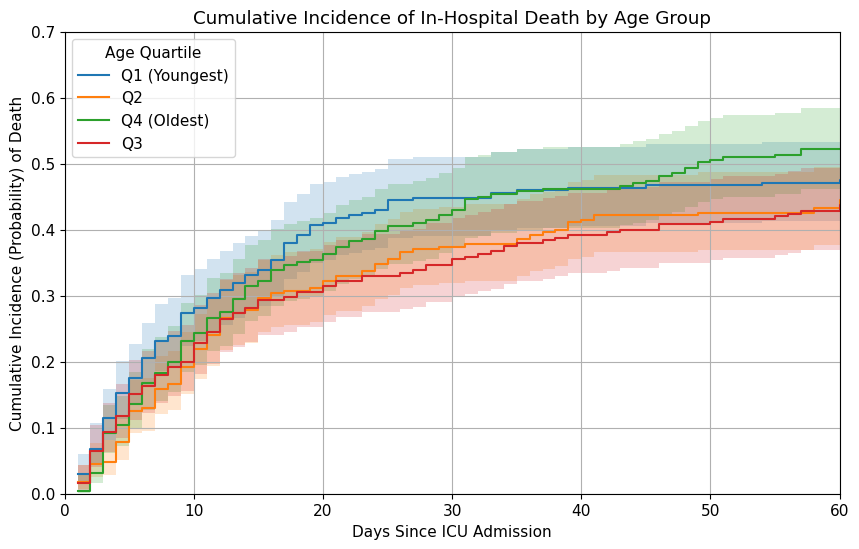

In [23]:
# --- 1. Prepare Data for the Plot ---
# We use data from the training set only for this check.
# Event coding: 1 = death (event of interest), 2 = discharge (competing event)
event_type_train = np.where(train_df["event_death"] == 1, 1, 2)
time_train = train_df["duration_days"]
age_series = train_df["Age"]

# Create Age Bands (quartiles) for plotting
# The try/except block makes our code robust if quartiles can't be calculated
try:
    age_band = pd.qcut(age_series, q=4, labels=["Q1 (Youngest)", "Q2", "Q3", "Q4 (Oldest)"])
except Exception:
    edges = [age_series.min(), 50, 70, 85, age_series.max()]
    age_band = pd.cut(age_series, bins=edges, include_lowest=True)

# --- 2. Calculate and Plot the Cumulative Incidence ---
fig, ax = plt.subplots(figsize=(10, 6))

for label in age_band.unique():
    idx = (age_band == label)
    
    # Estimate CIF with pointwise confidence intervals
    time_points, cif, conf_int = cumulative_incidence_competing_risks(
        event=event_type_train[idx],
        time_exit=time_train[idx],
        conf_type="log-log"
    )
    
    # With our coding, the first row (index 0) of the output is for event 1 (death)
    ax.step(time_points, cif[0], where="post", label=label)
    ax.fill_between(time_points, conf_int[0, 0], conf_int[0, 1], step="post", alpha=0.2)

ax.set_title("Cumulative Incidence of In-Hospital Death by Age Group")
ax.set_xlabel("Days Since ICU Admission")
ax.set_ylabel("Cumulative Incidence (Probability) of Death")
ax.set_xlim(0, 60)
ax.set_ylim(0, 0.7)
ax.legend(title="Age Quartile")
ax.grid(True)
plt.show()

### Clinical Conclusions from the CIF Plot

* Confidence intervals for all age groups overlap substantially, showing no clear statistical difference
* The youngest group (**Q1, blue**) initially shows a higher absolute risk than the oldest (**Q4, green**)
* This crossing pattern suggests the effect of age is complex and changes over time
* The surprising early risk in the youngest group strongly suggests confounding by patient illness severity
* A simple interpretation of age is not possible; a multivariable model is essential

# 5. Multivariable Cox Proportional Hazards Model

Our previous analyses proved that looking at one variable at a time is misleading due to confounding. The solution is to build a **multivariable model**, which estimates the effect of each predictor while simultaneously controlling for the effects of all others.

We will use the preprocessing pipeline we defined in the previous step to ensure our data is clean and consistently formatted.

**What we do next**
* Combine our preprocessed features (`X_train_tr`) with the outcome data (`y_train`).
* Fit the `CoxPHFitter` model on this complete, preprocessed training dataset.
* Evaluate the model's performance by checking its concordance on both the training and validation sets.

In [24]:
# 5. Multivariable Cox proportional hazards model

# Safety checks
for name in ["X_train", "X_val", "y_train", "y_val"]:
    if name not in globals():
        raise NameError(f"{name} not defined. Ensure section 3.2 ran successfully")

# 1) Detect feature types and build preprocessor with utils
numeric_cols, categorical_cols = utils.detect_feature_types(X_train)
cox_preprocessor = utils.build_preprocessor(
    numeric_cols=numeric_cols,
    categorical_cols=categorical_cols,
    num_strategy="median",
    cat_strategy="most_frequent"
)

# 2) Fit on TRAIN ONLY and transform splits
cox_preprocessor.fit(X_train)
X_train_cox = utils.to_dataframe(cox_preprocessor, X_train)
X_val_cox   = utils.to_dataframe(cox_preprocessor, X_val)

# 3) Build modeling frames for lifelines
train_cox_df = pd.concat([X_train_cox, y_train[["duration_days", "event_death"]]], axis=1)
val_cox_df   = pd.concat([X_val_cox,   y_val[["duration_days", "event_death"]]],   axis=1)

# 4) Fit Cox PH with Efron ties and a small L2 penalizer for stability
cph_multi = CoxPHFitter(penalizer=0.01)
cph_multi.fit(train_cox_df, duration_col="duration_days", event_col="event_death")

print("--- Multivariable Cox model summary ---")
cph_multi.print_summary(
    decimals=3,
    columns=["coef", "exp(coef)", "exp(coef) lower 95%", "exp(coef) upper 95%", "p"]
)

# 5) Concordance baseline
cindex_train = float(cph_multi.concordance_index_)
cindex_val = float(cph_multi.score(val_cox_df, scoring_method="concordance_index"))
print(f"\nConcordance | train {cindex_train:.3f} | validation {cindex_val:.3f}")

# Keep objects for next steps
cox_feature_names = X_train_cox.columns.tolist()


--- Multivariable Cox model summary ---


<lifelines.CoxPHFitter: fitted with 1029 total observations, 641 right-censored observations>
             duration col = 'duration_days'
                event col = 'event_death'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1029
number of events observed = 388
   partial log-likelihood = -2556.611
         time fit was run = 2025-10-16 14:59:07 UTC

---
              coef exp(coef) exp(coef) lower 95% exp(coef) upper 95%       p
covariate                                                                   
num__Age    -0.007     0.994               0.987               1.000   0.066
num__Gender -0.083     0.920               0.750               1.129   0.425
num__SAPS-I  0.010     1.010               0.990               1.031   0.334
num__SOFA    0.085     1.088               1.057               1.120 <0.0005
num__Weight -0.002     0.998               0.993               1.002   0.300
num__CCU    -0.124     0.883               0.658               1.185   0.409
num__CSRU   -0.867     0.420               0.294               0.600 <0.0005
num__SICU    0.124     1.132               0.893               1.434   0.306
---
Concordance = 0.634
Partial AIC = 5129.222
log-likelihood ratio test = 84.662 on 8 df
-log2(p) of ll-ratio test = 47.342


Concordance | train 0.634 | validation 0.659


### Multivariable Cox Model: Final Interpretation

This model untangles the independent effect of each admission-time factor after accounting for all others. Here is the definitive interpretation of the results.

---
#### What the Model Says

* **Overall fit is moderate** with a validation concordance of **0.659**
* **SOFA score is the dominant driver** of risk (**HR 1.088**, p < 0.001)
    * A clinically meaningful 5-point increase in SOFA implies a **~52% higher risk** (HR ≈ 1.52)
* **Age is near-neutral after adjustment** and not statistically significant (**HR 0.994**, p = 0.066)
* **The CSRU unit shows a strong protective effect** (**HR 0.420**, p < 0.001) vs the reference medical ICU
* **SAPS-I's effect is smaller** when SOFA is included, as they measure similar aspects of patient acuity
* **Gender, Weight, CCU, and SICU** are not statistically significant in this model

---
#### Clinical Takeaways

* **Use SOFA for risk stratification** as it's the strongest indicator of a patient's risk
* **Treat the effect of age as complex** and non-linear, not a simple per-year risk factor
* **Adjust for ICU type in comparisons**, as baseline risk is very different across units like the CSRU
* **Performance is reasonable but can be improved** with richer features or more flexible modeling terms

## 5.1. Proportional Hazards Assumption Check

The model's main assumption is that the effect of each variable (its Hazard Ratio) is **constant over time**. e.g. it assumes the risk from a high `SOFA` score is the same on Day 2 as it is on Day 20. We test to ensure our conclusions are reliable.

We use a built-in `lifelines` function that performs a statistical test for each variable and plots the "Schoenfeld residuals" for any that might violate the assumption.

**What we are looking for**
* **Statistical Test**: A p-value greater than 0.05 for a variable suggests it meets the assumption
* **Residual Plot**: The plot should look like random noise with no obvious trend. A clear slope or pattern in the plot is a red flag that the variable's effect changes over time


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.

Covariates to scrutinize first: ['num__Age', 'num__SOFA', 'num__CCU', 'num__CSRU', 'num__SICU']


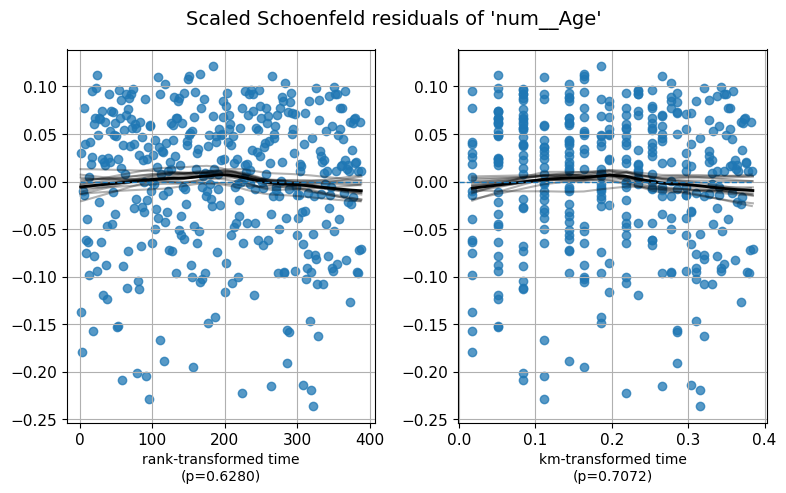

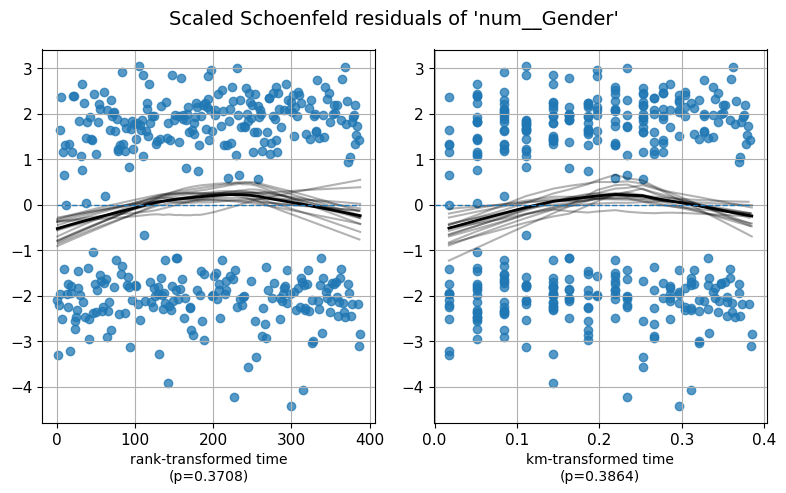

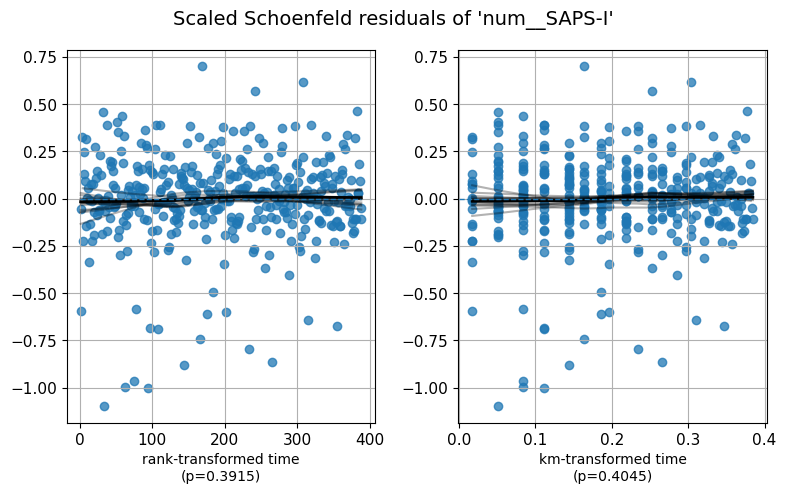

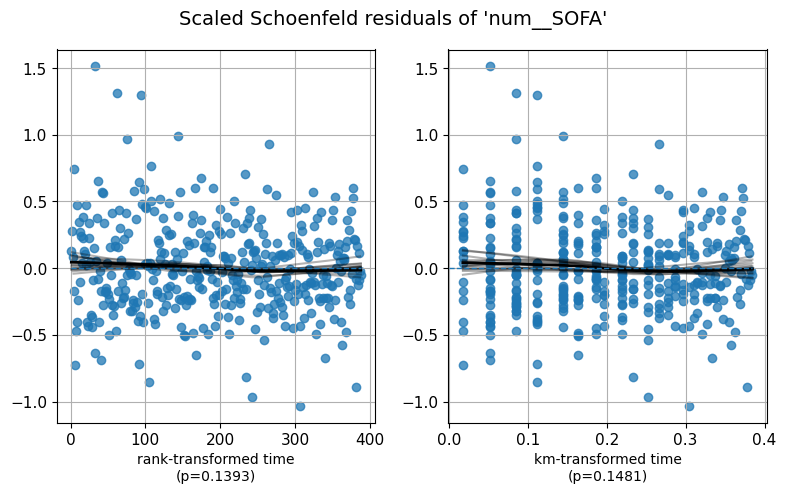

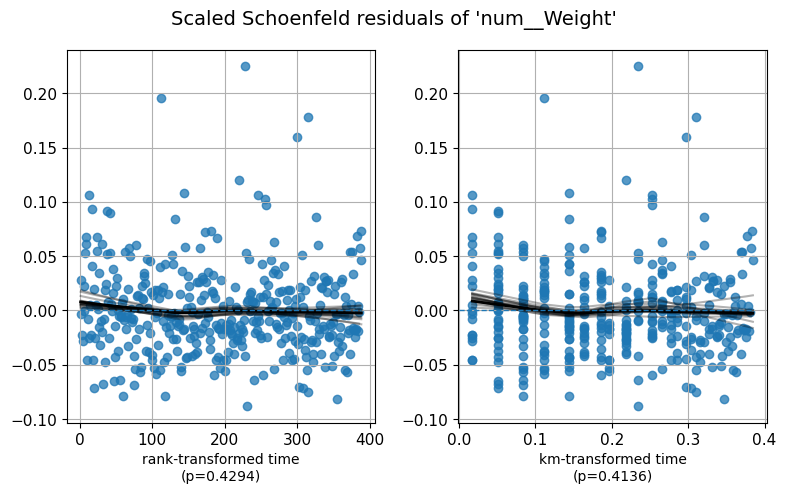

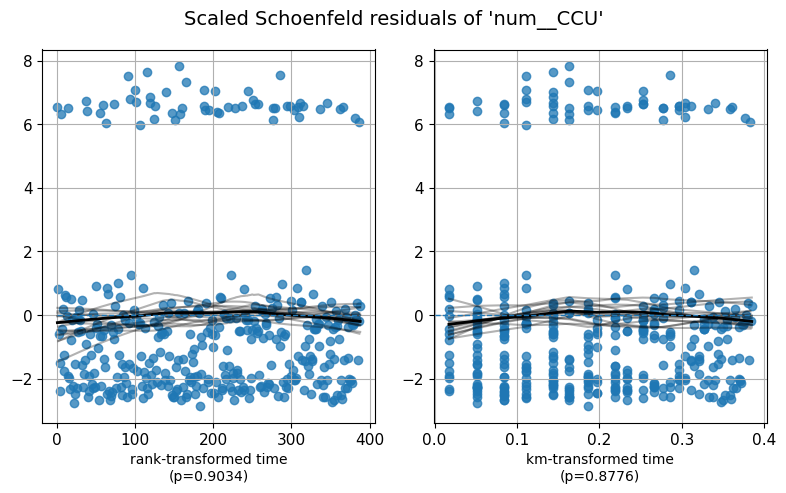

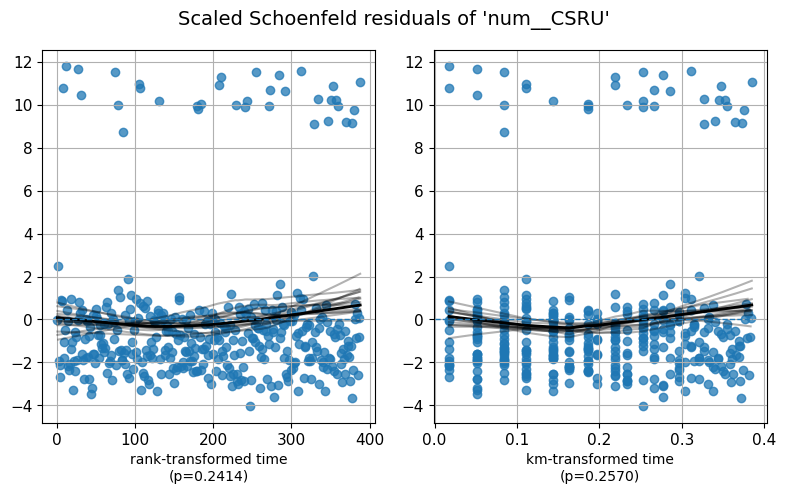

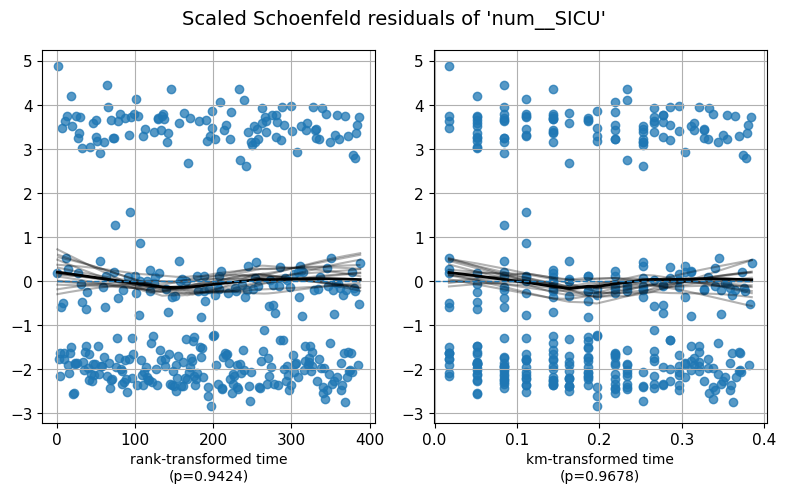

In [25]:
# --- 1. Run the Proportional Hazards Assumption Check ---
# We use the fitted multivariable model (cph_multi) and the processed training data
# The function will automatically flag any variables that fail the test (p < 0.05)

cph_multi.check_assumptions(
    training_df=train_cox_df,
    p_value_threshold=0.05,
    show_plots=True
)

# 2) Convenience: print the covariate names that might be most at risk of non-PH
suspect_terms = [c for c in train_cox_df.columns if any(k in c.lower() for k in ["sofa", "ccu", "csru", "sicu", "age"])]
print("\nCovariates to scrutinize first:", suspect_terms)


### What to Do if the Assumption Fails?

If a variable fails the PH test, it does not mean the model is useless, but it means we need a more advanced technique to model that variable correctly.

* **Common Remedies**
    If a key variable (like `SOFA` or an ICU type) fails the test:
    1.  **Stratification**: We can stratify the model by that variable (e.g., `strata=['ICUType']`). This allows each stratum (each ICU type) to have its own unique baseline hazard, relaxing the PH assumption
    2.  **Time-Varying Covariates**: For a continuous variable like `SOFA`, we could include an interaction term with time (e.g., `SOFA * log(time)`)

## 5.2 Forest Plot: Visualizing the Model's Results

The summary table gives us the precise numbers, but a **forest plot** helps us see the results at a glance. It's a standard way to visualize the output of a regression model.

How to Read the Forest Plot
- Each variable from our model is on the y-axis
- The x-axis shows the **Hazard Ratio (HR)**
- The dot represents the HR for that variable
- The horizontal line through the dot is the **95% confidence interval**
- The vertical dashed line is at HR = 1.0 (no effect)
- If a variable's confidence interval (the horizontal line) does **not** cross the vertical "no effect" line, it is statistically significant

--- Forest Plot of Multivariable Cox Model ---


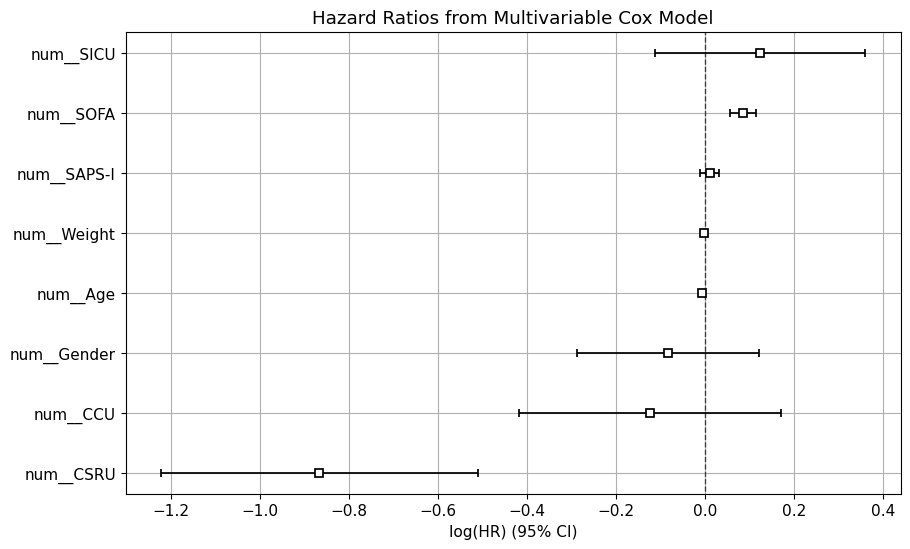

In [26]:
# The lifelines library has a convenient built-in function to create a forest plot.
# This is much simpler than building it manually.

print("--- Forest Plot of Multivariable Cox Model ---")
fig, ax = plt.subplots(figsize=(10, 6))

cph_multi.plot(ax=ax)

ax.set_title("Hazard Ratios from Multivariable Cox Model")
plt.show()

**Clinical insight from the forest plot**

- SOFA is clearly associated with higher instantaneous risk HR ≈ 1.09 per point with a narrow CI entirely above 1  
    - Clinically, a 5 point increase implies HR ≈ 1.5
- CSRU shows a strong protective association vs the reference ICU HR ≈ 0.42 with a CI entirely below 1  
    - Likely reflects different case mix and perioperative pathways
- Age, SAPS-I, Gender, Weight, CCU, SICU have CIs that cross 1 so they are not statistically significant in this multivariable model
- The x axis is on the log(HR) scale for plotting convenience interpret effects on the HR scale exp(coef)
- Use these effects for explanation and triage guidance not absolute risk

# 6. Individualized Prediction and Risk Separation

Now let's shift our focus from population-level explanations to **individualized prediction**. We'll use our model to assign a risk score (hazard) to each patient and see how well it separates them into different risk groups (cohorts)

1. **Calculate a risk score** for each patient in the test set using the Cox model
2. **Divide patients into four risk groups** (quartiles) based on the distribution of risk in the **training set** (to prevent data leakage)
3. **Visualize the separation** of these groups on the test set using KM curves and quantify it with a log-rank test
4. **Calculate the C-index** on the test set to measure the model's discriminative power

#### Clinical considerations
- A good model should show **clear separation** between the KM curves for the different risk quartiles
- The **Concordance Index (C-index)** is a metric that quantifies such discrimination i.e. the probability that, for a random pair of patients, the patient who experiences the event first had a higher risk score predicted by the model. A C-index of **0.5 is random chance**, vs. **1.0 as a perfect prediction**

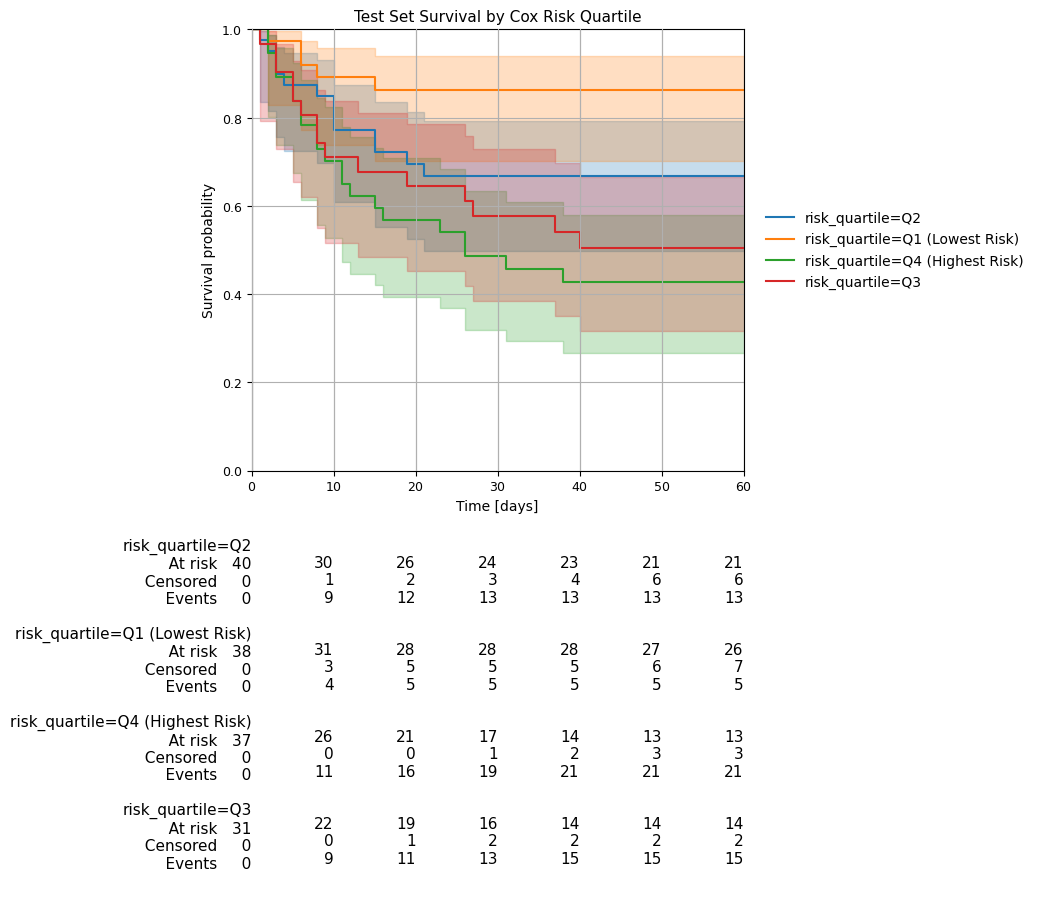

In [27]:
# Data preparation steps 1-3 remain the same
# 1) Transform features
X_test_cox = utils.to_dataframe(cox_preprocessor, X_test)
X_train_cox = utils.to_dataframe(cox_preprocessor, X_train)

# 2) Compute risk scores and define quartiles on the training set
risk_train = cph_multi.predict_partial_hazard(X_train_cox).values
risk_test = cph_multi.predict_partial_hazard(X_test_cox).values

q1, q2, q3 = np.quantile(risk_train, [0.25, 0.50, 0.75])
bins = [-np.inf, q1, q2, q3, np.inf]
labels = ["Q1 (Lowest Risk)", "Q2", "Q3", "Q4 (Highest Risk)"]
test_groups = pd.cut(risk_test, bins=bins, labels=labels, include_lowest=True)

# 3) Prepare evaluation DataFrame for the test set
test_eval_df = pd.concat(
    [y_test[["duration_days", "event_death"]].copy(),
     pd.Series(test_groups, index=X_test_cox.index, name="risk_quartile")],
    axis=1
).rename(columns={"duration_days": "duration", "event_death": "event"})

# 4) Plot with a larger figure size
fig, ax, logrank = utils.km_by_group(
    df=test_eval_df,
    group_col="risk_quartile",
    time_col="duration",
    event_col="event",
    xmax=60,
    show_table=True,
    figsize=(10, 6)
)

ax.set_title("Test Set Survival by Cox Risk Quartile", fontsize=11)
ax.set_xlabel(ax.get_xlabel(), fontsize=10)
ax.set_ylabel(ax.get_ylabel(), fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=9)

for item in ax.texts:
    item.set_fontsize(9)

ax.legend(
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    fontsize=10
)

fig.subplots_adjust(right=0.75, bottom=0.2)
plt.show()

**Clinical Insights**
- **Discrimination is not Calibration**: This plot shows the model is good at *ranking* patients by risk. It does not prove the predicted probabilities are accurate. We must check calibration separately with Brier scores and calibration plots
- **Association is not Causation**: The risk groups are based on associations in the data. We cannot use these groups alone to recommend specific treatments
- **Data Limitations**: The widening confidence intervals and noisy "tails" of the curves. Conclusions should be focused on the earlier, more stable parts of the curves

## 6.2 Personalized Survival Predictions

The risk quartiles showed that the model does a moderate job separating group of patients. Now, let's visualizing the full survival curve for specific individuals. This transforms the model's **abstract risk score into a tangible, time-dependent forecast for a given patient**

We will select two patients from the **test set**:
1. One with the lowest predicted risk
2. One with the highest

Plotting their predicted survival functions, will illustrate the practical implications of the model's predictions.

**Pitfalls & Consideratin**
- Do not report beyond the study follow-up window since extrapolation is unreliable  
- Predictions rely on the proportional hazards assumption and the estimated baseline  
- Associations in Cox are not causal, avoid treatment recommendations based solely on these numbers  

Feature values for the selected low-risk and high-risk patients:


,num__Age,num__Gender,num__SAPS-I,num__SOFA,num__Weight,num__CCU,num__CSRU,num__SICU
2098,79.0,1.0,14.0,2.0,80.0,0.0,1.0,0.0
1519,50.0,1.0,26.0,20.0,77.0,0.0,0.0,0.0


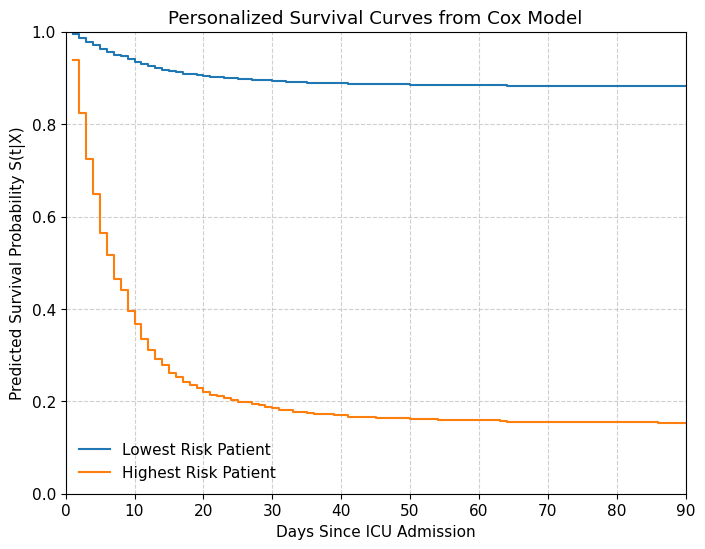


--- Fixed-Horizon Predictions ---



,Low-Risk Survival,Low-Risk Mortality,High-Risk Survival,High-Risk Mortality
7-Day,95.02%,4.98%,46.51%,53.49%
30-Day,89.34%,10.66%,18.51%,81.49%
60-Day,88.43%,11.57%,15.87%,84.13%


In [28]:
# Requires: X_test_cox, risk_test, cph_multi from the previous cell
# Produces: A plot of survival curves for two example patients and their fixed-horizon survival probabilities

# 1. Find the index for the lowest and highest-risk patients in the TEST set
low_risk_idx  = X_test_cox.index[np.argmin(risk_test)]
high_risk_idx = X_test_cox.index[np.argmax(risk_test)]
patient_pair_df = X_test_cox.loc[[low_risk_idx, high_risk_idx]]

print("Feature values for the selected low-risk and high-risk patients:")
display(patient_pair_df)

# 2. Predict the full survival functions for these two patients
# The result is a DataFrame with time-points as the index and patients as columns
survival_functions = cph_multi.predict_survival_function(patient_pair_df)

# 3. Plot the personalized survival curves
plt.figure(figsize=(8, 6))
plt.step(survival_functions.index, survival_functions.iloc[:, 0], where="post", label="Lowest Risk Patient")
plt.step(survival_functions.index, survival_functions.iloc[:, 1], where="post", label="Highest Risk Patient")

plt.xlim(0, 90)
plt.ylim(0, 1)
plt.xlabel("Days Since ICU Admission")
plt.ylabel("Predicted Survival Probability S(t|X)")
plt.title("Personalized Survival Curves from Cox Model")
plt.legend(frameon=False)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 4. Extract survival probabilities and display them in a formatted table
eval_times = [7.0, 30.0, 60.0]
sf_at_times = cph_multi.predict_survival_function(patient_pair_df, times=eval_times)

# Create a clean DataFrame for the results
results_df = pd.DataFrame({
    'Low-Risk Patient': sf_at_times.iloc[:, 0].values,
    'High-Risk Patient': sf_at_times.iloc[:, 1].values
}, index=[f"{int(t)}-Day" for t in eval_times])

# Add mortality risk columns
results_df['Low-Risk Mortality'] = 1 - results_df['Low-Risk Patient']
results_df['High-Risk Mortality'] = 1 - results_df['High-Risk Patient']

# Rename survival columns for clarity
results_df.rename(columns={'Low-Risk Patient': 'Low-Risk Survival', 'High-Risk Patient': 'High-Risk Survival'}, inplace=True)

print("\n--- Fixed-Horizon Predictions ---\n")
# Display the styled DataFrame
display(results_df[['Low-Risk Survival', 'Low-Risk Mortality', 'High-Risk Survival', 'High-Risk Mortality']].style.format("{:.2%}").set_caption("Predicted Survival & Mortality Risk"))

#### Interpreting Individual Predictions

**The Low-Risk Patient**
- **Curve Shape**: The survival curve is high and flat, indicating a very low and stable mortality risk after the initial ICU period
- **Implication**: This forecast supports a standard care pathway. The output suggests the patient is on a good trajectory, allowing for early planning for step-down care or discharge once clinical criteria are met. The 60-day predicted mortality risk is minimal

**The High-Risk Patient**
- **Curve Shape**: The curve shows a steep, rapid decline in the first 7-14 days before it starts to flatten. A pattern of a period of critical, concentrated early risk
- **Implication**: This forecast highlights a need for intensified monitoring, especially during the first week. The high early mortality risk (e.g., ~30% at 7 days) provides a quantitative basis for initiating early goals-of-care conversations with the patient and family

**Watchouts & Limitations**
- **Association, Not Causation**: These predictions identify high-risk patients; they do not explain the cause of that risk. Do not make treatment decisions based on the model's output alone
- **Assumptions Matter**: The curve's shape is dependent on the proportional hazards assumption
- **Avoid Extrapolation**: Do not make predictions beyond the follow-up period of the study (~90 days), as the data becomes too sparse to be reliable

## 6.3 Time-Dependent Model Performance

The **Concordance (C-index)** gives us a single number for model performance over the entire follow-up period e.g. 90 days. However, in a clinical setting, performance at specific time points is often more important:

_**"How well does our model predict the risk of in-ICU death at 7 days, 30 days, and 60 days, for the set of patients still in the ICU at those times?"**_

Remeber, in our case, we're not predicting the *absolute* 7-day mortality for a new patient. Instead, we are evaluating the *cause-specific hazard* performance at different points in time

Key metrics:

1.  **Time-Dependent AUC**: This measures the model's **discrimination** at a specific time *t*. It quantifies how well the model's risk score distinguishes between patients who die *in the ICU* before time *t* and those who survive *in the ICU* beyond time *t*

2.  **Brier Score**: This measures the model's overall prediction accuracy for the **cause-specific hazard**. It calculates the error between the predicted survival probabilities and the actual outcomes (in-ICU death or censoring) at time *t*

In [29]:
# --- 1. Setup ---
eval_times = np.array([7.0, 30.0, 60.0], dtype=float)
y_train_surv = Surv.from_arrays(
    event=y_train["event_death"].astype(bool).to_numpy(),
    time=y_train["duration_days"].to_numpy(dtype=float)
)
y_test_surv = Surv.from_arrays(
    event=y_test["event_death"].astype(bool).to_numpy(),
    time=y_test["duration_days"].to_numpy(dtype=float)
)


# --- 2. Time-Dependent AUC (Corrected Logic) ---
def get_auc_at_time(t):
    """
    Robustly calculates AUC at a single time t, handling data insufficiency
    and varied output formats from the scikit-survival library.
    """
    # Check for sufficient data in both train and test sets
    events_train = y_train["event_death"].astype(bool)
    times_train = y_train["duration_days"]
    train_ok = (events_train & (times_train <= t)).any() and (times_train > t).any()
    
    events_test = y_test["event_death"].astype(bool)
    times_test = y_test["duration_days"]
    test_ok = (events_test & (times_test <= t)).any() and (times_test > t).any()
    
    if not (train_ok and test_ok):
        return np.nan
    
    # Calculate AUC
    raw_output = cumulative_dynamic_auc(y_train_surv, y_test_surv, risk_test, [t])
    
    # Handle inconsistent return formats from the library
    # Sometimes it returns a tuple (times, scores), sometimes just scores
    if isinstance(raw_output, tuple):
        auc_scores_array = raw_output[1]
    else:
        auc_scores_array = raw_output
        
    # Ensure the result is a 1D array and return the first (and only) score
    return np.atleast_1d(auc_scores_array)[0]

# Calculate AUC for each time point
auc_scores = [get_auc_at_time(t) for t in eval_times]


# --- 3. Brier Score Calculation ---
sf_at_times = cph_multi.predict_survival_function(X_test_cox, times=eval_times)
survival_prob_matrix = sf_at_times.T.to_numpy()
_, brier_scores = brier_score(y_train_surv, y_test_surv, survival_prob_matrix, eval_times)


# --- 4. Assemble and Display Results ---
performance_df = pd.DataFrame({
    "Time Horizon (Days)": eval_times.astype(int),
    "Time-Dependent AUC": auc_scores,
    "Brier Score": brier_scores
})

print("\n--- Time-Dependent Model Performance ---\n")
display(performance_df.style.format({
    "Time-Dependent AUC": "{:.3f}",
    "Brier Score": "{:.3f}"
}).hide(axis="index"))


--- Time-Dependent Model Performance ---



Time Horizon (Days),Time-Dependent AUC,Brier Score
7,0.631,0.124
30,0.681,0.202
60,0.712,0.203


#### Clinical Insights & Interpretation

**How to Read These Numbers**
- The **AUC scores** suggests the model has moderate, but not exceptional, ability to rank patients by risk. However, it becomes very useful towards the end of the periord
- The **Brier scores** quantify the prediction error (MSE). Lower is better. The scores increase over time. It is harder to make accurate predictions further into the future as clinical uncertainty and the impact of censoring accumulate

**Limitations**
- These metrics treat discharge as non-informative censoring. They are evaluating the model's ability to predict **in-ICU death**, not the absolute probability of death in the presence of the competing event of discharge
- A "good" Brier score is context-dependent. To better understand its performance, we would ideally compare it to a baseline model (e.g., one that always predicts the average survival rate)

## 6.4 Comparing the Model to a Simple Baseline

But are these numbers good? To find out, we need to compare them to a reference point.

We'll create a simple **baseline model** that ignores all patient-specific features. It predicts the same survival probability for every patient, based on the overall survival rate of the training cohort (calculated with a Kaplan-Meier estimator).

By comparing our Cox model to this naive baseline, we can calculate the **Brier Skill Score (BSS)**. This tells us how much better our model is than simply guessing the population average. A positive BSS means our model has learned useful patterns from the patient data.

In [30]:
# 1. Fit a Kaplan-Meier estimator on the TRAINING data to create the baseline
kmf_baseline = KaplanMeierFitter()
kmf_baseline.fit(y_train["duration_days"], y_train["event_death"])

# 2. Get the baseline survival probability predictions at our evaluation times
# This gives one probability for each time point, which we apply to all test patients
baseline_surv_probs = np.asarray(kmf_baseline.predict(eval_times).values)

# 3. Create the prediction matrix required by brier_score
# We repeat the baseline predictions for every patient in the test set
n_test_patients = len(y_test_surv)
baseline_pred_matrix = np.tile(baseline_surv_probs, (n_test_patients, 1))

# 4. Calculate the Brier score for this baseline model
_ , baseline_brier_scores = brier_score(
    y_train_surv, y_test_surv, baseline_pred_matrix, eval_times
)

# 5. Calculate the Brier Skill Score (BSS)
# 'brier_scores' is the brier score from our Cox model in the previous cell
brier_skill_scores = 1 - (brier_scores / baseline_brier_scores)

# 6. Display the results in a comparative table
results_df = pd.DataFrame({
    'Cox Model Brier Score': brier_scores,
    'Baseline Brier Score': baseline_brier_scores,
    'Brier Skill Score (BSS)': brier_skill_scores
}, index=[f"{int(t)}-Day" for t in eval_times])

print("\n--- Brier Score Comparison ---\n")
display(results_df.style.format("{:.3f}"))


--- Brier Score Comparison ---



,Cox Model Brier Score,Baseline Brier Score,Brier Skill Score (BSS)
7-Day,0.124,0.129,0.044
30-Day,0.202,0.224,0.097
60-Day,0.203,0.231,0.122


#### Clinical Insights

- The Brier Skill Score (BSS) is positive at all time horizons. Confirming the clinical features used by the Cox model provide significantly better predictions than a simple, non-informative baseline

- The advantage over the baseline *increases* at longer time horizons. While making long-term predictions is inherently harder, our Cox model's ability to stratify patients becomes even more valuable for these more difficult forecasts

- Indeed, the model leverages patient-specific data to create forecasts that are substantially more accurate than just using the population average, especially for longer-term outcomes

## 6.5 Estimating True Absolute Risk with a Competing Risks Model

We now address the competing risk of discharge directly. Our goal now, is to answer a most clinically relevant question:

_**"What is the actual probability that a patient will die in the hospital by "day 7", considering they could be discharged first?"**_

**The Cause-Specific Hazards Method**
To solve this, we will build two separate Cox models, as a standard/ robust approach:

1.  **The Death Model**: Predicts the hazard of *death* (treating discharge as censoring).
2.  **The Discharge Model**: Predicts the hazard of *discharge* (treating death as censoring).

We will then combine the hazards from both models to calculate the **Cumulative Incidence Function (CIF)**. The CIF gives us the true, absolute probability of death over time.

3. Finally, we will check how well our model is **calibrated** by comparing its average predicted risk to the actual observed risk in the test set

In [31]:
# 6.5 Competing risks with cause-specific Cox focused on 7 days

# 0) Ensure we have an explicit discharge indicator
for df_name in ["y_train", "y_val", "y_test"]:
    if df_name in globals():
        df = globals()[df_name]
        if "event_discharge" not in df.columns:
            df["event_discharge"] = (df["event_death"] == 0).astype(int)

COMPETING_COL = "event_discharge"
H = np.array([7.0, 30.0, 60.0], dtype=float)  # we still compute all, but 7 d is the focus

# 1) Preprocess features
X_tr = utils.to_dataframe(cox_preprocessor, X_train)
X_te = utils.to_dataframe(cox_preprocessor, X_test)

# 2) Cause-specific training frames
def _cs(X_df, y_df, event_col):
    out = pd.concat(
        [X_df.reset_index(drop=True),
         y_df[["duration_days", "event_death", COMPETING_COL]].reset_index(drop=True)],
        axis=1
    )
    out["event_for_model"] = (out[event_col] == 1).astype(int)
    return out[["duration_days", "event_for_model"] + list(X_df.columns)]

df_tr_death = _cs(X_tr, y_train, "event_death")
df_tr_disc  = _cs(X_tr, y_train, COMPETING_COL)

# 3) Fit cause-specific Cox models
cph_death = CoxPHFitter().fit(df_tr_death, "duration_days", "event_for_model", show_progress=False)
cph_disc  = CoxPHFitter().fit(df_tr_disc,  "duration_days", "event_for_model", show_progress=False)

# 4) Predict patient-level CIF of death on the TEST set
pred_cif_df = utils.predict_cif_from_csh(cph_death, cph_disc, X_te, H)  # CIF_7d, CIF_30d, CIF_60d
display(pred_cif_df.round(3).head(10))

# 5) Calibration at 7 days using nonparametric CIF by quartile
calib_7d_df = utils.check_calibration_competing_risk_at(
    y_true=y_test,
    predictions=pred_cif_df["CIF_7d"],
    duration_col="duration_days",
    event_col="event_death",
    competing_col=COMPETING_COL,
    horizon_days=7.0,
    n_bins=4
).rename(columns={"pred_mean_risk": "pred_mean_risk_7d", "obs_risk": "obs_risk_7d"}).round(3)

display(calib_7d_df)


,CIF_7d,CIF_30d,CIF_60d
1097,0.142,0.296,0.317
2531,0.188,0.378,0.403
3389,0.134,0.280,0.300
1493,0.098,0.210,0.226
149,0.246,0.471,0.497
3579,0.139,0.289,0.310
2943,0.114,0.241,0.258
708,0.149,0.308,0.329
2426,0.118,0.248,0.265
844,0.078,0.169,0.183


,risk_quartile,n,pred_mean_risk_7d,obs_risk_7d
0,Q1 lowest,37,0.087,0.108
1,Q2,36,0.131,0.139
2,Q3,36,0.176,0.167
3,Q4 highest,37,0.262,0.216


### Interpreting Our Model's 7-Day Performance

Here we evaluate our model's predictions at the crucial **7-day** mark. This analysis tells us how much we can trust the raw probabilities our model produces

#### What the Tables Show

* The fisrt table lists each patient's specific probability of dying in the hospital within 7 days. The model's direct output
* The second table is our "reality check." We group patients by their predicted risks and compare the *average predicted risk* to the *actual death rate* observed in that group

#### Insights

* **The model is good at ranking.** The observed death rate correctly increases as the predicted risk goes up
* **The raw probabilities are relatively quite accurate.** The model slightly **underestimates** risk for the lowest-risk patients but is very close to reality for everyone else

#### Clinical Takeaway

* Use the **raw 7-day risk rankings** to prioritize which patients need the most attention
* For making decisions based on specific risk thresholds (e.g., >10% risk), the **raw probabilities are reliable**

## 6.6 Improving our Predictions with Calibration

To recalibrate our model, and ensure further medical usefulness and reliability, we'll use **Isotonic Regression** (Think of it as a smart "corrector" that learns the systematic error in our model's predictions)

- Fit isotonic regression on training evaluable patients  
- Apply to test predictions  
- Show quartile calibration and a familiar sklearn calibration plot

,risk_quartile,n,pred_raw_7d,pred_cal_7d,observed_7d
0,Q1 lowest,37,0.087,0.071,0.108
1,Q2,36,0.131,0.196,0.139
2,Q3,36,0.176,0.269,0.167


,model,brier_7d,n_test_evaluable
0,Cox_CIF raw 7d,0.124,145
1,Cox_CIF calibrated 7d,0.129,145


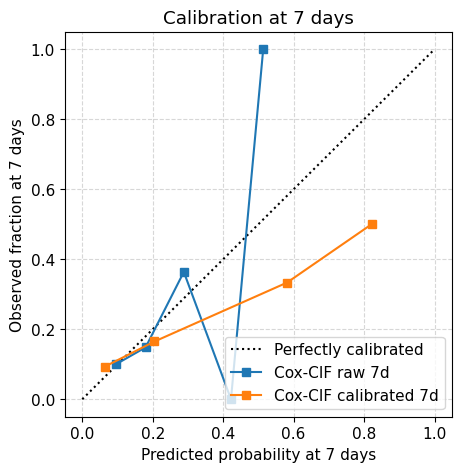

In [32]:
# 6.6 Isotonic calibration at 7 days
# 1) Raw 7 d probabilities from the same competing-risk models used above
p_train_raw_7 = utils.predict_cif_from_csh(cph_death, cph_disc, X_tr, np.array([7.0]))["CIF_7d"]
p_test_raw_7  = pred_cif_df["CIF_7d"]

# 2) Fixed-horizon labels and evaluable masks at 7 d
y_tr_7, eval_tr_7 = utils.get_fixed_horizon_labels(y_train, 7.0)
y_te_7, eval_te_7 = utils.get_fixed_horizon_labels(y_test, 7.0)

# 3) Fit isotonic on TRAIN evaluable and apply to TEST
iso_7 = IsotonicRegression(out_of_bounds="clip")
iso_7.fit(p_train_raw_7[eval_tr_7], y_tr_7[eval_tr_7])

p_test_cal_7 = pd.Series(iso_7.transform(p_test_raw_7), index=p_test_raw_7.index, name="p_cal_7d")

# 4) Calibration by quartile on TEST at 7 d: before vs after vs observed
cal_raw_7 = utils.check_calibration_competing_risk_at(
    y_true=y_test,
    predictions=p_test_raw_7,
    duration_col="duration_days",
    event_col="event_death",
    competing_col=COMPETING_COL,
    horizon_days=7.0
).rename(columns={"pred_mean_risk": "pred_raw_7d", "obs_risk": "observed_7d"})

cal_cal_7 = utils.check_calibration_competing_risk_at(
    y_true=y_test,
    predictions=p_test_cal_7,
    duration_col="duration_days",
    event_col="event_death",
    competing_col=COMPETING_COL,
    horizon_days=7.0
).rename(columns={"pred_mean_risk": "pred_cal_7d"})

calibr_table_7d = (
    cal_raw_7.merge(cal_cal_7[["risk_quartile", "pred_cal_7d"]], on="risk_quartile")
             .loc[:, ["risk_quartile", "n", "pred_raw_7d", "pred_cal_7d", "observed_7d"]]
             .round(3)
)
display(calibr_table_7d)

# 5) Brier score on TEST evaluable patients at 7 d: before vs after
brier_7d_df = pd.DataFrame({
    "model": ["Cox_CIF raw 7d", "Cox_CIF calibrated 7d"],
    "brier_7d": [
        brier_score_loss(y_te_7[eval_te_7], p_test_raw_7[eval_te_7]),
        brier_score_loss(y_te_7[eval_te_7], p_test_cal_7[eval_te_7])
    ],
    "n_test_evaluable": int(eval_te_7.sum())
}).round({"brier_7d": 3})
display(brier_7d_df)

# 6) Familiar sklearn visualization for evaluable TEST patients at 7 d
utils.plot_calibration_at_horizon(
    y_true_bin=y_te_7,
    y_prob_raw=p_test_raw_7.to_numpy(copy=False),
    y_prob_cal=p_test_cal_7.to_numpy(copy=False),
    mask=eval_te_7,
    horizon_days=7.0,
    n_bins=8
)


#### What the plot shows

* A perfectly accurate model would have its line fall directly on the **dashed diagonal**.
* **The Raw Model (Blue Line)** represents our original Cox model. Although a bit jagged because there are few deaths within 7 days
* **The Calibrated Model (Orange Line)** shows the "corrected" predictions. It now falls **below** the diagonal. A line below the diagonal means that for a given predicted risk, the actual observed risk is lower. Therefore, the model is now **overestimating** the risk

* In this case the isotonic calibration made the predictions **less accurate** for this specific 7-day horizon. However, we would prefer False Positives over the opposite!

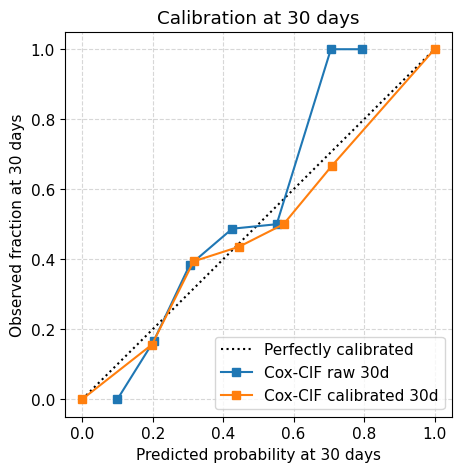

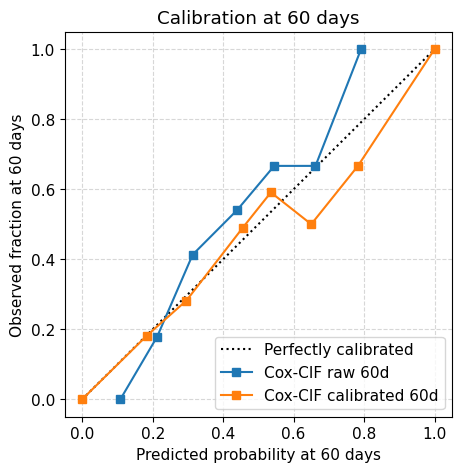

In [33]:
# Calibration plots at 30 and 60 days using the utils helper
# Horizons to visualize
H = [30.0, 60.0]

# Precompute design matrices if not already in memory
try:
    X_tr
    X_te
except NameError:
    X_tr = utils.to_dataframe(cox_preprocessor, X_train)
    X_te = utils.to_dataframe(cox_preprocessor, X_test)

for h in H:
    # 1) Raw probabilities from the competing-risk Cox models
    p_train_raw_h = utils.predict_cif_from_csh(cph_death, cph_disc, X_tr, np.array([h]))[f"CIF_{int(h)}d"]
    p_test_raw_h  = utils.predict_cif_from_csh(cph_death, cph_disc, X_te, np.array([h]))[f"CIF_{int(h)}d"]

    # 2) Fixed-horizon labels and evaluable mask
    y_tr_h, eval_tr_h = utils.get_fixed_horizon_labels(y_train, h)
    y_te_h, eval_te_h = utils.get_fixed_horizon_labels(y_test,  h)

    # 3) Horizon-specific isotonic calibration fitted on TRAIN evaluable patients
    iso_h = IsotonicRegression(out_of_bounds="clip")
    iso_h.fit(p_train_raw_h[eval_tr_h], y_tr_h[eval_tr_h])

    # 4) Plot sklearn-style calibration on TEST evaluable patients
    p_test_cal_h = iso_h.transform(p_test_raw_h)
    utils.plot_calibration_at_horizon(
        y_true_bin=y_te_h,
        y_prob_raw=p_test_raw_h.to_numpy(copy=False),
        y_prob_cal=p_test_cal_h,
        mask=eval_te_h,
        horizon_days=h,
        n_bins=8
    )
